In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

from nltk import TweetTokenizer
from torch import nn
from transformers import BertModel
from torch.utils.data import Dataset
import torch.nn.functional as F

from transformers import BertTokenizer

In [2]:
import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

In [3]:
pd.set_option('display.max_colwidth', None)

## Configurações do BERT

Habilitando GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Tokenizer

In [5]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
tokenizer_bert = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Exemplo com o BertTokenizer

In [6]:
sample_txt = "Mano eu não gosto do Bolsonaro, mas amo meu país"

tokens_basic = tokenizer_bert.tokenize(sample_txt)
tokens = tokenizer_bert.encode_plus(
    sample_txt,
    add_special_tokens=True,
    max_length=200,
    return_token_type_ids=False,
    padding=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt',
)

print(tokens_basic)
print(tokens)

['Mano', 'eu', 'não', 'gosto', 'do', 'Bols', '##ona', '##ro', ',', 'mas', 'amo', 'meu', 'país']
{'input_ids': tensor([[  101,  8419,  2779,   346, 10303,   171, 20354,   716,   157,   117,
           449, 14283,  7343,   806,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


### Modelo

In [7]:
class TweetDataset(Dataset):

    def __init__(self, texts, clean_texts, sentiments, tokenizer, max_len):
        self.texts = texts
        self.clean_texts = clean_texts
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        clean_text = str(self.clean_texts[item])
        target = self.sentiments[item] if self.sentiments is not None else None

        encoding = self.tokenizer.encode_plus(
            clean_text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'clean_text': clean_text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'sentiment': torch.tensor(target, dtype=torch.long) if target is not None else None
        }

In [8]:
from torch.utils.data import DataLoader

def create_data_loader(dataframe, tokenizer, max_len, batch_size):
    ds = TweetDataset(
        texts=dataframe.text.to_numpy(),
        clean_texts = dataframe.clean_text.to_numpy(),
        sentiments= dataframe.sentiment.to_numpy() if 'sentiment' in dataframe.columns  else None,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [9]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.2)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        output = self.drop(pooled_output)
        return self.out(output)

Criação do modelo

In [10]:
class_names = ['Negativo', 'Positivo']

sentiment_model = SentimentClassifier(len(class_names))
sentiment_model = sentiment_model.to(device)

## Métodos de treino e validação

In [11]:
EPOCHS = 5
BATCH_SIZE = 8
MAX_LEN = 200
LR = 2e-5

In [12]:
def train_epoch(
        model,
        data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader.dataset:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["sentiment"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs[0], targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader.dataset:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["sentiment"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs.squeeze(0), targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [13]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

def sep_data(dataframe: pd.DataFrame, test_size = 0.2) :
    dataframe = dataframe.sample(frac=1)
    df_train, df_test = train_test_split(dataframe, test_size=test_size, random_state=RANDOM_SEED)

    return df_train, df_test

def create_data_loaders(df_train, df_test):
    train_data_loader: DataLoader = create_data_loader(df_train, tokenizer_bert, MAX_LEN, BATCH_SIZE)
    test_data_loader = create_data_loader(df_test, tokenizer_bert, MAX_LEN, BATCH_SIZE)

    return train_data_loader, test_data_loader

In [14]:
from transformers import get_linear_schedule_with_warmup

def create_train_conf(len_df_train):
    optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=LR)
    total_steps = len_df_train * EPOCHS

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    loss_fnr = nn.CrossEntropyLoss().to(device)

    return optimizer, scheduler, loss_fnr

## Dados

### Pré-processamento

In [18]:
def normalize(text: pd.Series)-> pd.Series:
    return text.str.lower()

def remove_hashtags(df: pd.DataFrame):
    df.clean_text.replace(r'#\w+', ' ', regex=True, inplace=True)

def remove_link(df: pd.DataFrame):
    df.clean_text.replace(r'((?=(https://|http://))\S+)', ' ', regex=True, inplace=True)

def remove_tags(df: pd.DataFrame):
    # Remove marcações com exceção das marcações às contas oficiais dos candidatos
    df.clean_text.replace(r'@(?!(lulaoficial|jairbolsonaro|haddad_fernando))[^ ]*', ' ', regex=True, inplace=True)

def sub_linebreak(df: pd.DataFrame):
    df.clean_text.replace(r'\n', ' ', regex=True, inplace=True)

def remove_special_ch(df: pd.DataFrame):
    # Remoção de caracteres especiais e saltos de linha
    df.clean_text.replace(r'[^\w ]', ' ', regex=True, inplace=True)

def remove_rt(df: pd.DataFrame):
    df.clean_text.replace(r'(?=(rt |RT ))[^ ]*', '', regex=True, inplace=True)

def remove_empty(df: pd.DataFrame):
    df.drop(df[df.clean_text.str.fullmatch(r'\s*')].index, inplace=True)
    df.reset_index(drop=True, inplace=True)

def remove_len1(df: pd.DataFrame):
    indexes = list()
    for index, row in df.iterrows():
        words = TweetTokenizer().tokenize(row['clean_text'])
        if len(words) == 1:
            indexes.append(index)
    df.drop(indexes, inplace=True)

def clean_whitespaces(df: pd.DataFrame):
    df.clean_text.replace(r'  +', ' ', inplace=True, regex=True)
    df.clean_text.replace(r'^ ', '', inplace=True, regex=True)

In [19]:
def preprocess(df_param: pd.DataFrame):
    df = df_param.copy()
    df['clean_text'] = normalize(df.text)
    sub_linebreak(df)
    remove_hashtags(df)
    remove_link(df)
    remove_tags(df)
    remove_special_ch(df)
    remove_rt(df)

    clean_whitespaces(df)
    remove_empty(df)
    remove_len1(df)
    return df

In [20]:
def to_sentiment(polaridade: str):
    if polaridade == 'Negativo':
        return 0
    if polaridade == 'Positivo':
        return 1

### Carregando dados

In [18]:
tweets = pd.read_csv('tweets.csv')
tweets['sentiment'] = tweets.polaridade.apply(to_sentiment)
tweets.drop_duplicates(subset=['text'], inplace=True)
tweets = preprocess(tweets)

tweets

,Unnamed: 0,text,polaridade,sentiment,clean_text
0,0,RT @LannesDelRey: O Brasil viu o quanto Bolsonaro é machista ao momento que foi falar que Renata recebia menos q william Bonner.\n\nSimplesme…,Negativo,0,o brasil viu o quanto bolsonaro é machista ao momento que foi falar que renata recebia menos q william bonner simplesme
1,1,"RT @ArthurValim: Se você viu o #BolsonaroNoJornalNacional e ainda pretende votar nele, você não entende nada de política, nada de humanidad…",Negativo,0,se você viu o e ainda pretende votar nele você não entende nada de política nada de humanidad
2,2,"RT @AnaBiapax: #BolsonaroNoJornalNacional \nGeeentee isso é Barra da Tijuca 👇👇 Rio de Janeiro , Bolsonaroooo... é o povo clamando Mitooooooo…",Positivo,1,geeentee isso é barra da tijuca rio de janeiro bolsonaroooo é o povo clamando mitooooooo
3,3,"RT @crisvillarinho: Os caras no shopping, pararam pra assistir o Bolsonaro. E tem gente que ainda acredita em pesquisa! #BolsonaroNoJornalN…",Positivo,1,os caras no shopping pararam pra assistir o bolsonaro e tem gente que ainda acredita em pesquisa
4,5,"RT @Ro_Moller: Depois de ver a entrevista no JN, Globo News e toda repercussão no Twitter... Bolsonaro será ELEITO presidente por nocaute.…",Positivo,1,depois de ver a entrevista no jn globo news e toda repercussão no twitter bolsonaro será eleito presidente por nocaute
...,...,...,...,...,...
405,506,"RT @nasseroficial: Não é pelo PT\nNão é pelo Haddad\n\nÉ pelo bem maior que eu acredito, pela democracia e pela batalha de muitos que podem so…",Positivo,1,não é pelo pt não é pelo haddad é pelo bem maior que eu acredito pela democracia e pela batalha de muitos que podem so
406,507,RT @CarlaLukschal: Ordem e progresso é o que nós precisamos e queremos. 😎😎😎\n#OBrasilVota17 #APesardoPToBrasilVaiVencerB17 https://t.co/L6H5…,Positivo,1,ordem e progresso é o que nós precisamos e queremos
407,508,"RT @Samucatezu1: Ae, essa foi a eleição mais triste que eu já vi",Negativo,0,ae essa foi a eleição mais triste que eu já vi
408,509,"RT @blogdojefferson: Os petistas perdem uma eleição no voto, de forma legítima e incontestável, e Haddad vem falar que o partido vai contin…",Negativo,0,os petistas perdem uma eleição no voto de forma legítima e incontestável e haddad vem falar que o partido vai contin


### Treinamento

In [19]:
%%time

history = defaultdict(list)
best_accuracy = 0
loss_for_best_acc = 20

df_train, df_val = sep_data(tweets)

train_data_loader, val_data_loader = create_data_loaders(df_train, df_val)
optimizer, scheduler, loss_fn = create_train_conf(len(df_train))

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        sentiment_model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        sentiment_model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc.cpu())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.cpu())
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy or (val_acc == best_accuracy and val_loss < loss_for_best_acc):
        torch.save(sentiment_model.state_dict(), 'best_model.bin')
        best_accuracy = val_acc
        loss_for_best_acc = val_loss

Epoch 1/5
----------
Train loss 1.0104178471615675 accuracy 0.5914634146341463
Val   loss 1.0160006676437106 accuracy 0.7560975609756098

Epoch 2/5
----------
Train loss 0.7421595931082265 accuracy 0.8231707317073171
Val   loss 1.1114271556228832 accuracy 0.7682926829268293

Epoch 3/5
----------
Train loss 0.27795486783192824 accuracy 0.9390243902439025
Val   loss 1.3987644009949447 accuracy 0.7560975609756098

Epoch 4/5
----------
Train loss 0.09127135460882373 accuracy 0.9725609756097562
Val   loss 1.6051008149826396 accuracy 0.7317073170731707

Epoch 5/5
----------
Train loss 0.053721540902543205 accuracy 0.9878048780487805
Val   loss 1.6463157889396294 accuracy 0.7317073170731707

CPU times: user 2min 9s, sys: 769 ms, total: 2min 9s
Wall time: 2min 18s


## Métricas

**Acurácia**

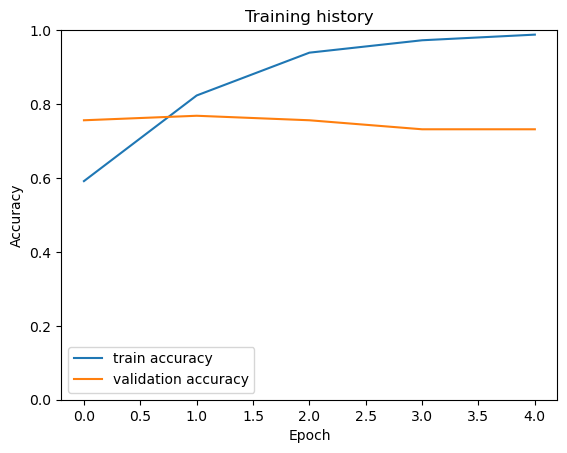

In [20]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

**Loss**

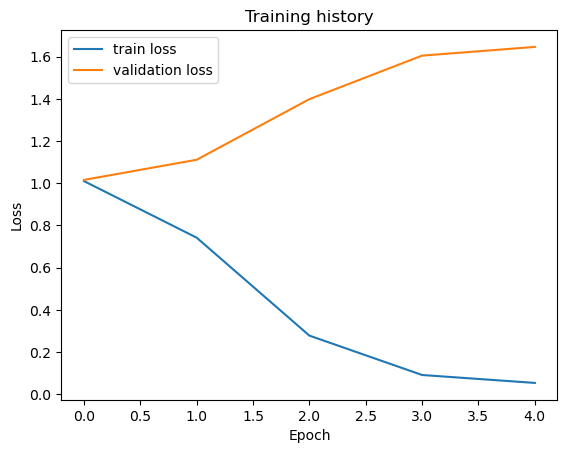

In [21]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

## Métricas

In [ ]:
model_val = SentimentClassifier(len(class_names))
model_val.load_state_dict(torch.load('best_model.bin'))
model_val = model_val.to(device)

In [116]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader.dataset:
            texts = d["clean_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["sentiment"].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)

            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.append(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets.unsqueeze(0))

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [117]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model_val, val_data_loader)

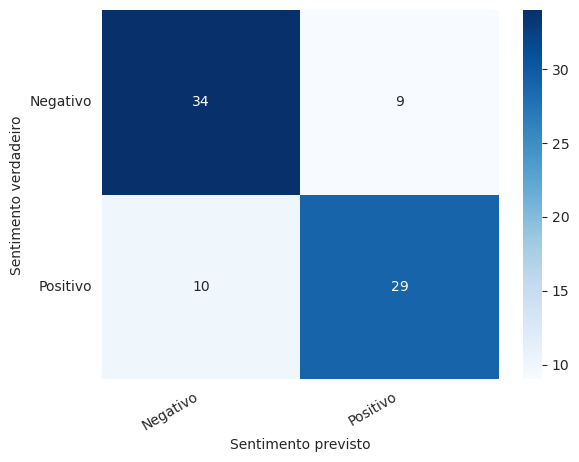

In [121]:
import numpy as np
from sklearn.metrics import confusion_matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('Sentimento verdadeiro')
    plt.xlabel('Sentimento previsto')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [120]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negativo       0.77      0.79      0.78        43
    Positivo       0.76      0.74      0.75        39

    accuracy                           0.77        82
   macro avg       0.77      0.77      0.77        82
weighted avg       0.77      0.77      0.77        82



## Previsão

Carregando o modelo

In [21]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model.bin'))
model = model.to(device)

Carregando os dados para previsão

In [22]:
tweets_prev = pd.read_csv('2Turno.csv', dtype= {'Coordenadas': 'str'})
tweets_prev.drop(columns=['Usuario', 'Localizacao', 'Coordenadas'], inplace=True)
tweets_prev.rename({'Mensagem': 'text'}, axis=1, inplace=True)

tweets_prev.dropna(subset=['text'], inplace=True)

tweets_prev = preprocess(tweets_prev)

In [14]:
#Bolsonaro
bwords = ['jair', 'bolsonaro']

#Haddad
hwords = ['haddad', 'lula']

In [24]:
tweets_bolsonaro = tweets_prev[tweets_prev.clean_text.str.contains('|'.join(bwords))]
print('Quantidade de tweets que citam Bolsonaro:', len(tweets_bolsonaro))

Quantidade de tweets que citam Bolsonaro: 72699


In [25]:
tweets_haddad = tweets_prev[tweets_prev.clean_text.str.contains('|'.join(hwords))]
print('Quantidade de tweets que citam Haddad:', len(tweets_haddad))

Quantidade de tweets que citam Haddad: 47889


In [26]:
indexes = set(tweets_bolsonaro.index)
indexes = indexes.union(tweets_haddad.index)
print('Quantidade de tweets que citam algum dos 2 candidatos:', len(indexes))

Quantidade de tweets que citam algum dos 2 candidatos: 107582


In [27]:
tweets_prev.drop(index=tweets_prev.index.difference(indexes), inplace=True)

In [28]:
tweets_prev

,text,clean_text
2,"RT @Kaio1908: Sou nordestino, eleitor do Bolsonaro, nunca votei no PT, nunca apoiei a esquerda. Voto no Bolsonaro, pq acredito em uma melho…",sou nordestino eleitor do bolsonaro nunca votei no pt nunca apoiei a esquerda voto no bolsonaro pq acredito em uma melho
8,RT @vtsbotafogo: Nem juntando duas hashtags eles conseguem os de Bolsonaro. kkkkkkkkkkkkk #OBrasilVota17 https://t.co/ha4FbijvBZ,nem juntando duas hashtags eles conseguem os de bolsonaro kkkkkkkkkkkkk
10,RT @chrisPLgalvao: #OBrasilVota17!\nBolsonaro será o presidente do Brasil!\nAmém! https://t.co/WrLZLsjcQg,bolsonaro será o presidente do brasil amém
23,RT @ricado_burgari: GALERA URGENTE ESTA CIRCULANDO QUE A CAMPANHA DE BOLSONARO ESTA PEDINDO PARA ENVIAR O COMPROVANTE DE VOTO COM O NUMERO…,galera urgente esta circulando que a campanha de bolsonaro esta pedindo para enviar o comprovante de voto com o numero
25,"RT @artur_slo: #OBrasilVota17 \nPronto para gritar duas coisas hoje.\n""É Bolsonaro! Viva o Brasil.""\n""É fraude! Vamos para as ruas.""\nNão tem h…",pronto para gritar duas coisas hoje é bolsonaro viva o brasil é fraude vamos para as ruas não tem h
...,...,...
601789,RT @Estadao: Mensaleiro Roberto Jefferson celebra eleição de Bolsonaro: ‘A vitória é nossa’ https://t.co/fny2GASMCA,mensaleiro roberto jefferson celebra eleição de bolsonaro a vitória é nossa
601790,RT @conexaopolitica: VÍDEO: Assista ao exato momento em que @jairbolsonaro recebeu o resultado oficial das Eleições 2018; o candidato do PS…,vídeo assista ao exato momento em que jairbolsonaro recebeu o resultado oficial das eleições 2018 o candidato do ps
601791,"RT @rosemarywarde: @Haddad_Fernando VOCÊ VAI SAIR GRANDE DESSAS ELEIÇÕES , VOCÊ FOI GUERREIRO FOI FIEL A TODOS SEUS PRINCÍPIOS ,ME SINTO O…",haddad_fernando você vai sair grande dessas eleições você foi guerreiro foi fiel a todos seus princípios me sinto o
601794,"RT @bellamoura18: Pós a declaração de vitoria de Jair Messias Bolsonaro ser declarada, eu proponho um twitaço para lembrar todos os ""artist…",pós a declaração de vitoria de jair messias bolsonaro ser declarada eu proponho um twitaço para lembrar todos os artist


**Criando a estruturação para a previsão**

In [29]:
tweets_prev_data_loader = create_data_loader(tweets_prev, tokenizer_bert, MAX_LEN, BATCH_SIZE)

**Método para previsão dos dados**

In [30]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    clean_texts = []
    predictions = []

    with torch.no_grad():
        for d in data_loader.dataset:
            text = d["text"]
            clean_text = d["clean_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)

            _, preds = torch.max(outputs, dim=1)

            texts.append(text)
            clean_texts.append(clean_text)
            predictions.extend(preds)

    predictions = torch.stack(predictions).cpu()

    return pd.DataFrame({'text': texts, 'clean_text': clean_texts, 'sentiment': predictions})

**Previsão**

In [31]:
%%time
preds = get_predictions(model, tweets_prev_data_loader)

CPU times: user 10min 55s, sys: 474 ms, total: 10min 55s
Wall time: 10min 58s


In [17]:
def to_polarity(sentiment: int):
    if sentiment == 0:
        return 'Negativo'
    if sentiment == 1:
        return 'Positivo'

In [33]:
preds.to_csv('results.csv', index=False)

In [12]:
preds = pd.read_csv('results.csv')

In [19]:
df = preds.copy()
df.loc[df.clean_text.str.contains('|'.join(hwords)), 'label'] = 'Haddad'
df.loc[df.clean_text.str.contains('|'.join(bwords)), 'label'] = 'Bolsonaro'

In [20]:
df = df.drop(columns=['text', 'clean_text']).groupby('label').value_counts().reset_index(name = 'amount')
df['Sentimento'] = df.sentiment.apply(to_polarity)

In [21]:
df

,label,sentiment,amount,Sentimento
0,Bolsonaro,1,45625,Positivo
1,Bolsonaro,0,27074,Negativo
2,Haddad,1,28405,Positivo
3,Haddad,0,6478,Negativo


## Plot dos resultados

**Quantidades totais por sentimento**

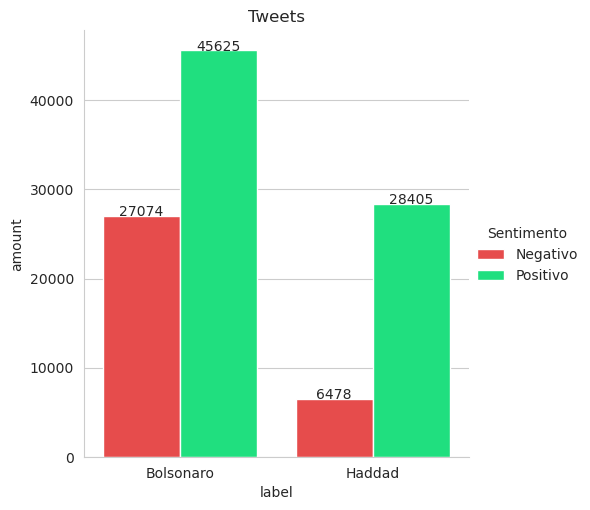

In [22]:
import seaborn as sns

sns.set_style("whitegrid")

green = '#00FF7F'
red = '#FF3333'
colors = sns.set_palette([red, green])

hue_order = ['Negativo', 'Positivo']

g = sns.catplot(data=df, x = 'label', y = 'amount', hue='Sentimento', hue_order=hue_order, kind='bar', palette=colors)

g.ax.set(title = 'Tweets')

for p in g.ax.patches:
    txt = str(int(p.get_height()))
    txt_x = p.get_x() + p.get_width()/2
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt, ha = 'center')

**Porcentagem de positivos por candidato**

In [23]:
df = preds.copy()
df = df.loc[df.sentiment == 1]
df.loc[df.clean_text.str.contains('|'.join(hwords)), 'label'] = 'Haddad'
df.loc[df.clean_text.str.contains('|'.join(bwords)), 'label'] = 'Bolsonaro'

df = df.drop(columns=['text', 'clean_text']).groupby('sentiment').value_counts(normalize=True).reset_index(name = 'percent')
df['percent'] = df['percent'].apply(lambda x: x*100)

In [24]:
df

,sentiment,label,percent
0,1,Bolsonaro,61.63042
1,1,Haddad,38.36958


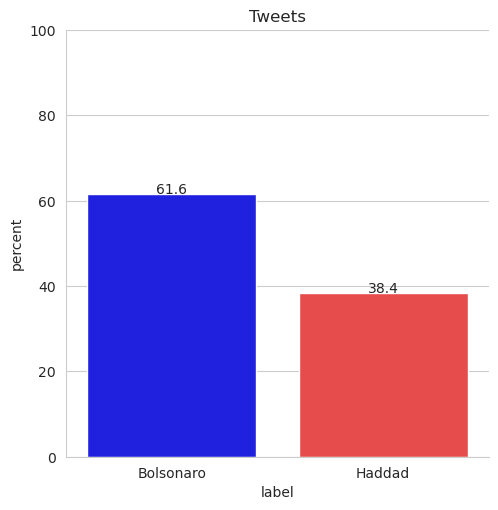

In [25]:
import seaborn as sns

sns.set_style("whitegrid")

blue = '#0000FF'
red = '#FF3333'
colors = sns.set_palette([blue, red])

g = sns.catplot(data=df, x = 'label', y = 'percent', kind='bar', palette=colors)
g.ax.set_ylim(0,100)

g.ax.set(title = 'Tweets')

for p in g.ax.patches:
    txt = str(round(p.get_height(), 1))
    txt_x = p.get_x() + p.get_width()/2
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt, ha = 'center')